In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

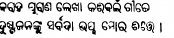

I'll help you create a markdown explanation of the Module class using LaTeX formatting for a Jupyter notebook. I'll break down the key components and add mathematical notation where appropriate.

# Neural Network Module Base Class

## Overview

The `Module` class serves as the foundational class for all models, inheriting from PyTorch's `nn.Module` and a custom `HyperParameters` class. Let's examine its core components.

## Class Definition

```python
class Module(nn.Module, d2l.HyperParameters):
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
```

## Essential Methods

### Loss Function
The abstract loss function that must be implemented by subclasses:

$$
\mathcal{L}(\hat{y}, y) \rightarrow \text{loss value}
$$

```python
def loss(self, y_hat, y):
    raise NotImplementedError
```

### Forward Pass
The forward computation expects a defined neural network:

$$
f(X; \theta) = \text{net}(X)
$$

```python
def forward(self, X):
    assert hasattr(self, 'net'), 'Neural network is defined'
    return self.net(X)
```

### Training Step
For each batch $\mathcal{B}$, computes and plots the loss:

$$
\text{step}(\mathcal{B}) = \mathcal{L}(f(X_\mathcal{B}), y_\mathcal{B})
$$

```python
def training_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    self.plot('loss', l, train=True)
    return l
```

### Validation Step
Similar to training step but for validation data:

$$
\text{validate}(\mathcal{B}) = \mathcal{L}(f(X_\mathcal{B}), y_\mathcal{B})
$$

```python
def validation_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    self.plot('loss', l, train=False)
```

### Progress Plotting
Visualizes training progress with the following parameters:
- Training points plotted per epoch: $n_{\text{train}} = 2$
- Validation points plotted per epoch: $n_{\text{valid}} = 1$

Training point position is calculated as:

$$
x_{\text{train}} = \frac{\text{batch\_idx}}{\text{num\_train\_batches}}
$$

Validation point position is:

$$
x_{\text{valid}} = \text{epoch} + 1
$$

## Notes

1. This class inherits from `nn.Module`, enabling automatic parameter management and the convenient calling interface:
   
   $$
   \text{model}(X) \equiv \text{model.forward}(X)
   $$

2. The `configure_optimizers` method must be implemented by subclasses to specify the optimization algorithm:

   $$
   \text{opt}(\theta, \nabla_\theta \mathcal{L})
   $$

3. Progress visualization frequency is controlled by:
   - `plot_train_per_epoch`: Points plotted during training per epoch
   - `plot_valid_per_epoch`: Points plotted during validation per epoch

In [1]:
import torch
import torch.nn as nn
import numpy as np
from typing import List, Tuple, Optional
from dataclasses import dataclass

class ProgressBoard:
    """Simple progress board for tracking and visualizing training metrics."""
    def __init__(self):
        self.xlabel = None
        self.metrics = {}
        
    def draw(self, x: float, y: float, metric_name: str, every_n: int = 1):
        if metric_name not in self.metrics:
            self.metrics[metric_name] = {'x': [], 'y': []}
        
        if len(self.metrics[metric_name]['x']) % every_n == 0:
            self.metrics[metric_name]['x'].append(x)
            self.metrics[metric_name]['y'].append(y)

class HyperParameters:
    """Mixin class for saving hyperparameters."""
    def save_hyperparameters(self):
        """Save arguments from __init__ as class attributes."""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k: v for k, v in local_vars.items() if k != 'self'}
        for k, v in self.hparams.items():
            setattr(self, k, v)

class Module(nn.Module, HyperParameters):
    """Base neural network module with training utilities."""
    
    def __init__(self, plot_train_per_epoch: int = 2, plot_valid_per_epoch: int = 1):
        """
        Initialize the module.
        
        Args:
            plot_train_per_epoch: Number of training points to plot per epoch
            plot_valid_per_epoch: Number of validation points to plot per epoch
        """
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
        self.trainer = None  # Will be set by Trainer class
        
    def loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Calculate loss between predictions and targets.
        Must be implemented by subclasses.
        """
        raise NotImplementedError
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.
        Requires self.net to be defined.
        """
        assert hasattr(self, 'net'), 'Neural network is not defined'
        return self.net(X)
        
    def plot(self, key: str, value: torch.Tensor, train: bool):
        """
        Plot a point in the progress animation.
        
        Args:
            key: Metric name
            value: Metric value
            train: Whether this is a training or validation metric
        """
        assert hasattr(self, 'trainer'), 'Trainer is not initialized'
        self.board.xlabel = 'epoch'
        
        if train:
            x = self.trainer.train_batch_idx / self.trainer.num_train_batches
            n = self.trainer.num_train_batches / self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / self.plot_valid_per_epoch
            
        self.board.draw(
            x=x,
            y=value.cpu().detach().numpy(),
            metric_name=('train_' if train else 'val_') + key,
            every_n=int(n)
        )
        
    def training_step(self, batch: Tuple[torch.Tensor, ...]) -> torch.Tensor:
        """
        Perform a training step on a batch of data.
        
        Args:
            batch: Tuple of (inputs..., targets)
        Returns:
            Loss value
        """
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
        
    def validation_step(self, batch: Tuple[torch.Tensor, ...]):
        """
        Perform a validation step on a batch of data.
        
        Args:
            batch: Tuple of (inputs..., targets)
        """
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)
        
    def configure_optimizers(self):
        """
        Configure optimizers for training.
        Must be implemented by subclasses.
        """
        raise NotImplementedError

# Example implementation of a simple regression model
class LinearRegression(Module):
    """Linear regression model implementation."""
    
    def __init__(self, input_dim: int, learning_rate: float = 0.01):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Linear(input_dim, 1)
        
    def loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Mean squared error loss."""
        return torch.mean((y_hat - y) ** 2)
        
    def configure_optimizers(self):
        """Configure SGD optimizer."""
        return torch.optim.SGD(self.parameters(), lr=self.learning_rate)

# Example implementation of a classification model
class MLPClassifier(Module):
    """Multi-layer perceptron classifier."""
    
    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int, 
                 learning_rate: float = 0.01):
        super().__init__()
        self.save_hyperparameters()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Cross entropy loss."""
        return nn.functional.cross_entropy(y_hat, y)
        
    def configure_optimizers(self):
        """Configure Adam optimizer."""
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

# Example usage
def train_model(model: Module, train_data, val_data, epochs: int = 10):
    """Simple training loop example."""
    optimizer = model.configure_optimizers()
    
    for epoch in range(epochs):
        # Training
        model.train()
        for batch in train_data:
            optimizer.zero_grad()
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            
        # Validation
        model.eval()
        with torch.no_grad():
            for batch in val_data:
                model.validation_step(batch)

In [ ]:
import torch
import torch.nn as nn
import math
import time
from IPython import display

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        """Add multiple data points into the figure."""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Module(nn.Module):
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.animator = Animator()
        self.training_stats = {'loss': [], 'epoch': []}
        self.validation_stats = {'loss': [], 'epoch': []}
        
    def save_hyperparameters(self):
        """Save function arguments into class attributes."""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items() if k != 'self'}
        for k, v in self.hparams.items():
            setattr(self, k, v)

    def loss(self, y_hat, y):
        """Calculate loss between predictions and targets."""
        raise NotImplementedError

    def forward(self, X):
        """Forward computation."""
        assert hasattr(self, 'net'), 'Neural network is not defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        
        if train:
            x = self.trainer.train_batch_idx / self.trainer.num_train_batches
            self.training_stats['loss'].append(value.item())
            self.training_stats['epoch'].append(x)
        else:
            x = self.trainer.epoch + 1
            self.validation_stats['loss'].append(value.item())
            self.validation_stats['epoch'].append(x)
            
        # Update plot
        self.animator.add(
            x=[x], 
            y=[value.item()]
        )

    def training_step(self, batch):
        """Perform one training step."""
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        """Perform one validation step."""
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        """Configure optimizer."""
        raise NotImplementedError

class LinearRegressionScratch(Module):
    """Linear regression implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

    def forward(self, X):
        """The linear regression model."""
        return torch.matmul(X, self.w) + self.b

    def loss(self, y_hat, y):
        """Mean squared error loss."""
        l = (y_hat - y.reshape(y_hat.shape)) ** 2
        return l.mean()

    def configure_optimizers(self):
        """Return optimizer."""
        return torch.optim.SGD([self.w, self.b], self.lr)

def train_epoch(model, train_iter, loss, optimizer):
    """Train the model for one epoch."""
    model.train()
    for batch in train_iter:
        optimizer.zero_grad()
        loss = model.training_step(batch)
        loss.backward()
        optimizer.step()

def train(model, train_iter, valid_iter, num_epochs):
    """Train the model."""
    optimizer = model.configure_optimizers()
    
    for epoch in range(num_epochs):
        train_epoch(model, train_iter, model.loss, optimizer)
        
        if valid_iter is not None:
            model.eval()
            with torch.no_grad():
                for batch in valid_iter:
                    model.validation_step(batch)

# Example usage:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

# Generate synthetic data
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

# Create data iterator
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

# Create and train model
model = LinearRegressionScratch(2, lr=0.03)
train(model, data_iter, None, num_epochs=3)

In [ ]:
import math
import random
from typing import List, Tuple, Optional

class Tensor:
    """Simple tensor implementation with autograd."""
    def __init__(self, data: List[List[float]], requires_grad: bool = False):
        self.data = data
        self.grad = None
        self.requires_grad = requires_grad
        self.grad_fn = None
        
    def __add__(self, other: 'Tensor') -> 'Tensor':
        result = Tensor([[self.data[i][j] + other.data[i][j]
                         for j in range(len(self.data[0]))]
                        for i in range(len(self.data))])
        if self.requires_grad or other.requires_grad:
            result.requires_grad = True
            result.grad_fn = ('add', self, other)
        return result
    
    def __mul__(self, other: 'Tensor') -> 'Tensor':
        result = Tensor([[self.data[i][j] * other.data[i][j]
                         for j in range(len(self.data[0]))]
                        for i in range(len(self.data))])
        if self.requires_grad or other.requires_grad:
            result.requires_grad = True
            result.grad_fn = ('mul', self, other)
        return result
    
    def matmul(self, other: 'Tensor') -> 'Tensor':
        result = [[sum(self.data[i][k] * other.data[k][j]
                      for k in range(len(other.data)))
                  for j in range(len(other.data[0]))]
                 for i in range(len(self.data))]
        tensor = Tensor(result)
        if self.requires_grad or other.requires_grad:
            tensor.requires_grad = True
            tensor.grad_fn = ('matmul', self, other)
        return tensor
    
    def mean(self) -> 'Tensor':
        total = sum(sum(row) for row in self.data)
        size = len(self.data) * len(self.data[0])
        result = Tensor([[total / size]])
        if self.requires_grad:
            result.requires_grad = True
            result.grad_fn = ('mean', self)
        return result
    
    def backward(self, grad: Optional['Tensor'] = None):
        if grad is None:
            grad = Tensor([[1.0]])
            
        if self.grad_fn is None:
            self.grad = grad
            return
            
        op, *inputs = self.grad_fn
        if op == 'add':
            for input_tensor in inputs:
                if input_tensor.requires_grad:
                    input_tensor.backward(grad)
        elif op == 'mul':
            for i, input_tensor in enumerate(inputs):
                if input_tensor.requires_grad:
                    other = inputs[1 - i]
                    input_grad = Tensor([[grad.data[0][0] * other.data[i][j]
                                        for j in range(len(other.data[0]))]
                                       for i in range(len(other.data))])
                    input_tensor.backward(input_grad)
        elif op == 'matmul':
            # Simplified gradient computation for matrix multiplication
            if inputs[0].requires_grad:
                inputs[0].backward(grad.matmul(inputs[1]))
            if inputs[1].requires_grad:
                inputs[1].backward(inputs[0].matmul(grad))

class Module:
    """Base neural network module."""
    def __init__(self):
        self.training = True
        self.parameters = []
    
    def zero_grad(self):
        """Zero out gradients of all parameters."""
        for param in self.parameters:
            param.grad = None
    
    def __call__(self, x: Tensor) -> Tensor:
        return self.forward(x)
    
    def forward(self, x: Tensor) -> Tensor:
        raise NotImplementedError

class Linear(Module):
    """Linear (fully connected) layer."""
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        # Initialize weights and bias
        self.weight = Tensor([[random.gauss(0, 0.01) 
                             for _ in range(in_features)]
                            for _ in range(out_features)],
                           requires_grad=True)
        self.bias = Tensor([[0.0] for _ in range(out_features)],
                          requires_grad=True)
        self.parameters = [self.weight, self.bias]
    
    def forward(self, x: Tensor) -> Tensor:
        return x.matmul(self.weight) + self.bias

class SGD:
    """Stochastic Gradient Descent optimizer."""
    def __init__(self, parameters: List[Tensor], lr: float = 0.01):
        self.parameters = parameters
        self.lr = lr
    
    def step(self):
        """Update parameters using their gradients."""
        for param in self.parameters:
            if param.grad is not None:
                for i in range(len(param.data)):
                    for j in range(len(param.data[0])):
                        param.data[i][j] -= self.lr * param.grad.data[i][j]
    
    def zero_grad(self):
        """Zero out gradients."""
        for param in self.parameters:
            param.grad = None

class MSELoss:
    """Mean Squared Error Loss."""
    def __call__(self, pred: Tensor, target: Tensor) -> Tensor:
        return ((pred + target * -1) * (pred + target * -1)).mean()

# Example usage:
def train_model():
    # Create synthetic data
    X = Tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    y = Tensor([[5.0], [11.0], [17.0]])
    
    # Create model
    model = Linear(2, 1)
    criterion = MSELoss()
    optimizer = SGD(model.parameters, lr=0.01)
    
    # Training loop
    losses = []
    for epoch in range(100):
        # Forward pass
        y_pred = model(X)
        loss = criterion(y_pred, y)
        losses.append(loss.data[0][0])
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.data[0][0]:.4f}')
    
    return losses

# Simple plotting function using ASCII art
def plot_losses(losses: List[float], width: int = 50, height: int = 20):
    """Plot losses using ASCII art."""
    if not losses:
        return
    
    min_loss = min(losses)
    max_loss = max(losses)
    loss_range = max_loss - min_loss
    
    canvas = [[' ' for _ in range(width)] for _ in range(height)]
    
    for i, loss in enumerate(losses):
        x = int((i / len(losses)) * (width - 1))
        y = int(((loss - min_loss) / loss_range) * (height - 1))
        y = height - 1 - y  # Flip y-axis
        canvas[y][x] = '*'
    
    # Print the plot
    print('\nLoss Plot:')
    print('-' * width)
    for row in canvas:
        print(''.join(row))
    print('-' * width)

# Run training and plot results
if __name__ == "__main__":
    losses = train_model()
    plot_losses(losses)

In [3]:
class Tensor:
    """Simple tensor implementation with autograd."""
    def __init__(self, data, requires_grad: bool = False):
        # Handle scalar inputs
        if isinstance(data, (int, float)):
            self.data = [[float(data)]]
        elif isinstance(data, list):
            # Handle 1D list
            if not isinstance(data[0], list):
                self.data = [data]
            else:
                self.data = [[float(x) for x in row] for row in data]
        else:
            raise TypeError("Data must be a number or a list")
            
        self.grad = None
        self.requires_grad = requires_grad
        self.grad_fn = None
        
    def shape(self):
        return (len(self.data), len(self.data[0]))
        
    def __add__(self, other: 'Tensor') -> 'Tensor':
        # Convert scalar to tensor if needed
        if isinstance(other, (int, float)):
            other = Tensor(other)
            
        # Handle broadcasting for scalar-like tensors
        if self.shape() == (1, 1):
            result = Tensor([[self.data[0][0] + other.data[i][j]
                            for j in range(len(other.data[0]))]
                           for i in range(len(other.data))])
        elif other.shape() == (1, 1):
            result = Tensor([[self.data[i][j] + other.data[0][0]
                            for j in range(len(self.data[0]))]
                           for i in range(len(self.data))])
        else:
            # Regular element-wise addition
            if len(self.data) != len(other.data) or len(self.data[0]) != len(other.data[0]):
                raise ValueError(f"Cannot add tensors of shapes {self.shape()} and {other.shape()}")
            result = Tensor([[self.data[i][j] + other.data[i][j]
                            for j in range(len(self.data[0]))]
                           for i in range(len(self.data))])
            
        if self.requires_grad or other.requires_grad:
            result.requires_grad = True
            result.grad_fn = ('add', self, other)
        return result
    
    def __mul__(self, other: 'Tensor') -> 'Tensor':
        # Convert scalar to tensor if needed
        if isinstance(other, (int, float)):
            other = Tensor(other)
            
        # Handle broadcasting for scalar-like tensors
        if self.shape() == (1, 1):
            result = Tensor([[self.data[0][0] * other.data[i][j]
                            for j in range(len(other.data[0]))]
                           for i in range(len(other.data))])
        elif other.shape() == (1, 1):
            result = Tensor([[self.data[i][j] * other.data[0][0]
                            for j in range(len(self.data[0]))]
                           for i in range(len(self.data))])
        else:
            # Regular element-wise multiplication
            if len(self.data) != len(other.data) or len(self.data[0]) != len(other.data[0]):
                raise ValueError(f"Cannot multiply tensors of shapes {self.shape()} and {other.shape()}")
            result = Tensor([[self.data[i][j] * other.data[i][j]
                            for j in range(len(self.data[0]))]
                           for i in range(len(self.data))])
            
        if self.requires_grad or other.requires_grad:
            result.requires_grad = True
            result.grad_fn = ('mul', self, other)
        return result
    
    def matmul(self, other: 'Tensor') -> 'Tensor':
        if len(self.data[0]) != len(other.data):
            raise ValueError(f"Cannot multiply matrices of shapes {self.shape()} and {other.shape()}")
            
        result = [[sum(self.data[i][k] * other.data[k][j]
                      for k in range(len(other.data)))
                  for j in range(len(other.data[0]))]
                 for i in range(len(self.data))]
        tensor = Tensor(result)
        if self.requires_grad or other.requires_grad:
            tensor.requires_grad = True
            tensor.grad_fn = ('matmul', self, other)
        return tensor
    
    def mean(self) -> 'Tensor':
        total = sum(sum(row) for row in self.data)
        size = len(self.data) * len(self.data[0])
        result = Tensor(total / size)
        if self.requires_grad:
            result.requires_grad = True
            result.grad_fn = ('mean', self)
        return result
    
    def backward(self, grad: Optional['Tensor'] = None):
        if grad is None:
            grad = Tensor(1.0)
            
        if self.grad_fn is None:
            if self.requires_grad:
                if self.grad is None:
                    self.grad = grad
                else:
                    self.grad = self.grad + grad
            return
            
        op, *inputs = self.grad_fn
        if op == 'add':
            for input_tensor in inputs:
                if input_tensor.requires_grad:
                    input_tensor.backward(grad)
        elif op == 'mul':
            for i, input_tensor in enumerate(inputs):
                if input_tensor.requires_grad:
                    other = inputs[1 - i]
                    input_grad = other * grad
                    input_tensor.backward(input_grad)
        elif op == 'matmul':
            # Simplified gradient computation for matrix multiplication
            if inputs[0].requires_grad:
                inputs[0].backward(grad.matmul(inputs[1]))
            if inputs[1].requires_grad:
                inputs[1].backward(inputs[0].matmul(grad))
        elif op == 'mean':
            if inputs[0].requires_grad:
                scale = 1.0 / (len(self.data) * len(self.data[0]))
                input_grad = Tensor([[scale * grad.data[0][0] 
                                    for _ in range(len(inputs[0].data[0]))]
                                   for _ in range(len(inputs[0].data))])
                inputs[0].backward(input_grad)

    def __str__(self):
        return f"Tensor(data={self.data}, requires_grad={self.requires_grad})"

# Test the fixed implementation
def test_tensor_operations():
    # Test scalar creation
    t1 = Tensor(5.0)
    print("Scalar tensor:", t1.data)
    
    # Test 1D list creation
    t2 = Tensor([1.0, 2.0, 3.0])
    print("1D tensor:", t2.data)
    
    # Test 2D list creation
    t3 = Tensor([[1.0, 2.0], [3.0, 4.0]])
    print("2D tensor:", t3.data)
    
    # Test addition
    result = t1 + t2
    print("Scalar + 1D tensor:", result.data)
    
    # Test multiplication
    result = t1 * t2
    print("Scalar * 1D tensor:", result.data)
    
    # Test matrix multiplication
    t4 = Tensor([[1.0, 2.0], [3.0, 4.0]])
    t5 = Tensor([[5.0, 6.0], [7.0, 8.0]])
    result = t4.matmul(t5)
    print("Matrix multiplication result:", result.data)

if __name__ == "__main__":
    test_tensor_operations()

Scalar tensor: [[5.0]]
1D tensor: [[1.0, 2.0, 3.0]]
2D tensor: [[1.0, 2.0], [3.0, 4.0]]
Scalar + 1D tensor: [[6.0, 7.0, 8.0]]
Scalar * 1D tensor: [[5.0, 10.0, 15.0]]
Matrix multiplication result: [[19.0, 22.0], [43.0, 50.0]]


# Neural Network Training Framework

## Data Module

The `DataModule` serves as the base class for handling data operations. It is represented formally as:

$$
\text{DataModule} := \{\mathcal{D}_{\text{train}}, \mathcal{D}_{\text{val}}, \text{root}, \text{num\_workers}\}
$$

### Key Components:
1. **Initialization**:
   $$
   \text{init}(\text{root}, \text{num\_workers}) \rightarrow \text{void}
   $$

2. **Data Loader Interface**:
   $$
   \text{get\_dataloader}(\text{train}: \text{bool}) \rightarrow \text{Iterator}[\mathcal{B}]
   $$
   where $\mathcal{B}$ represents a batch of data

3. **Specific Loaders**:
   - Training: $\text{train\_dataloader}() \rightarrow \text{Iterator}[\mathcal{B}_{\text{train}}]$
   - Validation: $\text{val\_dataloader}() \rightarrow \text{Iterator}[\mathcal{B}_{\text{val}}]$

## Trainer

The `Trainer` class orchestrates the training process. Its formal definition:

$$
\text{Trainer} := \{\text{model}, \text{data}, \text{max\_epochs}, \text{num\_gpus}, \text{gradient\_clip\_val}\}
$$

### Methods:

1. **Data Preparation**:
   $$
   \begin{align*}
   \text{prepare\_data}(\mathcal{D}) &\rightarrow \text{void} \\
   \text{num\_train\_batches} &= |\mathcal{D}_{\text{train}}| \\
   \text{num\_val\_batches} &= |\mathcal{D}_{\text{val}}|
   \end{align*}
   $$

2. **Model Preparation**:
   $$
   \text{prepare\_model}(M) \rightarrow \text{void}
   $$

3. **Training Loop**:
   $$
   \begin{align*}
   \text{fit}(M, \mathcal{D}) &\rightarrow \text{void} \\
   \text{epoch} &\in [0, \text{max\_epochs}) \\
   \text{train\_batch\_idx} &\in [0, |\mathcal{D}_{\text{train}}|) \\
   \text{val\_batch\_idx} &\in [0, |\mathcal{D}_{\text{val}}|)
   \end{align*}
   $$

### Training Process:

For each epoch $e \in [0, \text{max\_epochs})$:

1. Model training:
   $$
   \mathcal{L}_{\text{train}} = \frac{1}{|\mathcal{D}_{\text{train}}|} \sum_{\mathcal{B} \in \mathcal{D}_{\text{train}}} \text{model.training\_step}(\mathcal{B})
   $$

2. Validation (if available):
   $$
   \mathcal{L}_{\text{val}} = \frac{1}{|\mathcal{D}_{\text{val}}|} \sum_{\mathcal{B} \in \mathcal{D}_{\text{val}}} \text{model.validation\_step}(\mathcal{B})
   $$

Note: The actual implementation of `fit_epoch()` is deferred to specific model implementations, allowing for customization of the training process for different architectures and tasks.

In [4]:
class HyperParameters:
    """Stores and manages hyperparameters."""
    def save_hyperparameters(self):
        """Store hyperparameters from initialization."""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k: v for k, v in local_vars.items() 
                       if k != 'self' and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

class DataModule(HyperParameters):
    """Base class for data modules."""
    
    def __init__(self, root='../data', num_workers=4, batch_size=16):
        """
        Initialize DataModule.
        
        Args:
            root: Root directory for data
            num_workers: Number of workers for data loading
            batch_size: Batch size for data loaders
        """
        self.save_hyperparameters()
        self.train_data = None
        self.val_data = None
        
    def prepare_data(self):
        """
        Download and prepare raw data.
        Should be called only once and on 1 GPU.
        """
        pass
    
    def setup(self):
        """
        Process data operations: splitting, etc.
        Should be called on every GPU.
        """
        pass
    
    def get_dataloader(self, train=True):
        """Get a data loader for either training or validation."""
        data = self.train_data if train else self.val_data
        if data is None:
            return None
            
        start_idx = 0
        while start_idx < len(data):
            batch = data[start_idx:start_idx + self.batch_size]
            yield batch
            start_idx += self.batch_size
    
    def train_dataloader(self):
        """Get training data loader."""
        return self.get_dataloader(train=True)
    
    def val_dataloader(self):
        """Get validation data loader."""
        return self.get_dataloader(train=False)

class Trainer(HyperParameters):
    """Handles model training."""
    
    def __init__(self, max_epochs=10, num_gpus=0, gradient_clip_val=0):
        """
        Initialize Trainer.
        
        Args:
            max_epochs: Maximum number of epochs
            num_gpus: Number of GPUs (currently only CPU supported)
            gradient_clip_val: Gradient clipping value
        """
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'
        
    def prepare_data(self, data):
        """Prepare data loaders."""
        data.prepare_data()
        data.setup()
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        
        # Count number of batches
        self.num_train_batches = sum(1 for _ in data.train_dataloader())
        self.num_val_batches = (sum(1 for _ in data.val_dataloader())
                               if self.val_dataloader is not None else 0)
    
    def prepare_model(self, model):
        """Prepare model for training."""
        model.trainer = self
        if hasattr(model, 'board'):
            model.board.xlim = [0, self.max_epochs]
        self.model = model
    
    def fit(self, model, data):
        """
        Train the model with the given data.
        
        Args:
            model: Model to train
            data: DataModule instance with training data
        """
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    
    def fit_epoch(self):
        """Run one epoch of training and validation."""
        # Training phase
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(batch)
            self.optim.zero_grad()
            loss.backward()
            
            # Apply gradient clipping if specified
            if self.gradient_clip_val > 0:
                params = [p for p in self.model.parameters() if p.requires_grad]
                norm = math.sqrt(sum(p.grad.data.norm()**2 for p in params))
                if norm > self.gradient_clip_val:
                    for p in params:
                        p.grad.data *= self.gradient_clip_val / norm
            
            self.optim.step()
            self.train_batch_idx += 1
        
        # Validation phase
        if self.val_dataloader is not None:
            self.model.eval()
            with torch.no_grad():
                for batch in self.val_dataloader:
                    self.model.validation_step(batch)
                    self.val_batch_idx += 1

# Example implementation of a simple data module
class SimpleDataModule(DataModule):
    """Example data module for synthetic data."""
    
    def __init__(self, num_examples=1000, input_dim=10, 
                 root='../data', num_workers=4, batch_size=16):
        super().__init__(root, num_workers, batch_size)
        self.save_hyperparameters()
        
    def prepare_data(self):
        """Generate synthetic data."""
        rng = random.Random(42)
        # Generate random input data
        X = [[rng.random() for _ in range(self.input_dim)] 
             for _ in range(self.num_examples)]
        # Generate random target values
        y = [sum(x) / self.input_dim + 0.1 * rng.random() for x in X]
        
        # Split into train and validation
        split = int(0.8 * self.num_examples)
        self.train_data = list(zip(X[:split], y[:split]))
        self.val_data = list(zip(X[split:], y[split:]))

# Example usage
def train_example_model():
    # Create synthetic data
    data = SimpleDataModule(num_examples=1000, input_dim=10, batch_size=32)
    
    # Create model (assuming we have a SimpleModel class)
    model = SimpleModel(input_dim=10)
    
    # Create trainer
    trainer = Trainer(max_epochs=10)
    
    # Train the model
    trainer.fit(model, data)

In [ ]:
import random

class HyperParameters:
    """Stores and manages hyperparameters."""
    def save_hyperparameters(self):
        """Store hyperparameters from initialization."""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k: v for k, v in local_vars.items() 
                       if k != 'self' and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

class DataModule(HyperParameters):
    """Base class for data modules."""
    
    def __init__(self, root='../data', num_workers=4, batch_size=16):
        """
        Initialize DataModule.
        
        Args:
            root: Root directory for data
            num_workers: Number of workers for data loading
            batch_size: Batch size for data loaders
        """
        self.save_hyperparameters()
        self.train_data = None
        self.val_data = None
        
    def prepare_data(self):
        """
        Download and prepare raw data.
        Should be called only once and on 1 GPU.
        """
        pass
    
    def setup(self):
        """
        Process data operations: splitting, etc.
        Should be called on every GPU.
        """
        pass
    
    def get_dataloader(self, train=True):
        """Get a data loader for either training or validation."""
        data = self.train_data if train else self.val_data
        if data is None:
            return None
            
        start_idx = 0
        while start_idx < len(data):
            batch = data[start_idx:start_idx + self.batch_size]
            yield batch
            start_idx += self.batch_size
    
    def train_dataloader(self):
        """Get training data loader."""
        return self.get_dataloader(train=True)
    
    def val_dataloader(self):
        """Get validation data loader."""
        return self.get_dataloader(train=False)

class Trainer(HyperParameters):
    """Handles model training."""
    
    def __init__(self, max_epochs=10, num_gpus=0, gradient_clip_val=0):
        """
        Initialize Trainer.
        
        Args:
            max_epochs: Maximum number of epochs
            num_gpus: Number of GPUs (currently only CPU supported)
            gradient_clip_val: Gradient clipping value
        """
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'
        
    def prepare_data(self, data):
        """Prepare data loaders."""
        data.prepare_data()
        data.setup()
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        
        # Count number of batches
        self.num_train_batches = sum(1 for _ in data.train_dataloader())
        self.num_val_batches = (sum(1 for _ in data.val_dataloader())
                               if self.val_dataloader is not None else 0)
    
    def prepare_model(self, model):
        """Prepare model for training."""
        model.trainer = self
        if hasattr(model, 'board'):
            model.board.xlim = [0, self.max_epochs]
        self.model = model
    
    def fit(self, model, data):
        """
        Train the model with the given data.
        
        Args:
            model: Model to train
            data: DataModule instance with training data
        """
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    
    def fit_epoch(self):
        """Run one epoch of training and validation."""
        # Training phase
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(batch)
            self.optim.zero_grad()
            loss.backward()
            
            # Apply gradient clipping if specified
            if self.gradient_clip_val > 0:
                params = [p for p in self.model.parameters() if p.requires_grad]
                norm = math.sqrt(sum(p.grad.data.norm()**2 for p in params))
                if norm > self.gradient_clip_val:
                    for p in params:
                        p.grad.data *= self.gradient_clip_val / norm
            
            self.optim.step()
            self.train_batch_idx += 1
        
        # Validation phase
        if self.val_dataloader is not None:
            self.model.eval()
            with torch.no_grad():
                for batch in self.val_dataloader:
                    self.model.validation_step(batch)
                    self.val_batch_idx += 1

# Example implementation of a simple data module
class SimpleDataModule(DataModule):
    """Example data module for synthetic data."""
    
    def __init__(self, num_examples=1000, input_dim=10, 
                 root='../data', num_workers=4, batch_size=16):
        super().__init__(root, num_workers, batch_size)
        self.save_hyperparameters()
        
    def prepare_data(self):
        """Generate synthetic data."""
        rng = random.Random(42)
        # Generate random input data
        X = [[rng.random() for _ in range(self.input_dim)] 
             for _ in range(self.num_examples)]
        # Generate random target values
        y = [sum(x) / self.input_dim + 0.1 * rng.random() for x in X]
        
        # Split into train and validation
        split = int(0.8 * self.num_examples)
        self.train_data = list(zip(X[:split], y[:split]))
        self.val_data = list(zip(X[split:], y[split:]))

# Example usage
def train_example_model():
    # Create synthetic data
    data = SimpleDataModule(num_examples=1000, input_dim=10, batch_size=32)
    
    # Create model (assuming we have a SimpleModel class)
    model = SimpleModel(input_dim=10)
    
    # Create trainer
    trainer = Trainer(max_epochs=10)
    
    # Train the model
    trainer.fit(model, data)


## Synthetic Regression Data

Machine learning is all about extracting information from data. So you might wonder, what could we possibly learn from synthetic data? While we might not care intrinsically about the patterns that we ourselves baked into an artificial data generating model, such datasets are nevertheless useful for didactic purposes, helping us to evaluate the properties of our learning algorithms and to confirm that our implementations work as expected. For example, if we create data for which the correct parameters are known *a priori*, then we can verify that our model can in fact recover them.
if we create data for which the correct parameters are known a priori, then we can verify that our model can in fact recover them.



## Generating the Dataset

For this example, we will work low-dimensional for succinctness. The following code snippet generates 1000 examples with 2-dimensional features drawn from a standard normal distribution. The resulting design matrix X belongs to $\mathbb{R}^{1000\times2}$. We generate each label by applying a ground truth linear function, corrupted them via additive noise $\epsilon$, drawn independently and identically for each example:

$$y = Xw + b + \zeta. \quad (3.3.1)$$

For convenience, we assume that $\epsilon$ is drawn from a normal distribution with mean $\mu = 0$ and standard deviation $\sigma = 0.01$. Note that for object-oriented design, we add the code to the `__init__` method of a subclass of `d2l.DataModule` (introduced in Section 3.2.3). It is good practice to allow setting any additional hyperparameters. We accomplish this with `save_hyperparameters()`. The batch_size will be determined later on.

features: tensor([-0.0499, -0.2817])
label: tensor([5.0533])

``` python

%matplotlib inline
import random
import torch
from d import torch as d

class SyntheticRegressionData(d.DataModule):
    #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise


```
2. Reading the Dataset

Training machine learning models often requires multiple passes over a dataset, grabbing one minibatch of examples at a time. This data is then used to update the model. To illustrate how this works, we implement the `get_dataloader` method, registering it in the `SyntheticRe- gressionData` class via `add_to_class` (introduced in Section 3.2.1). It takes a batch size, a matrix of features, and a vector of labels, and generates minibatches of size `batch_size`. As such, each minibatch consists of a tuple of features and labels. Note that we need to be mindful of whether we’re in training or validation mode: in the former, we will want to read the data in random order, whereas for the latter, being able to read data in a pre-defined order may be important for debugging purposes.

```python
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))  # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train + self.num_val))

    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i + self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]
```

To build some intuition, let’s inspect the first minibatch of data. Each minibatch of features provides us with both its size and the dimensionality of input features. Likewise, our mini-batch of labels will have a matching shape given by `batch_size`.

```python
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)
```

```
X shape: torch.Size([32, 2])
y shape: torch.Size([32, 1])
```

While seemingly innocuous, the invocation of `iter(data.train_dataloader())` illus- trates the power of Python’s object-oriented design. Note that we added a method to the `SyntheticRegressionData` class after creating the data object. Nonetheless, the object beneﬁts from the ex post facto addition of functionality to the class. Throughout the iteration, we obtain distinct minibatches until the entire dataset has been ex- hausted (try this).

While the iteration implemented above is good for didactic purposes, it is ineﬃcient in ways that might get us in trouble on real problems. For example, it requires that we load all the data in memory and that we perform lots of random memory access. The built-in iterators implemented in a deep learning framework are considerably more eﬃcient and they can deal with sources such as data stored in ﬁles, data received via a stream, and data generated or processed on the ﬂy. Next, let’s try to implement the same method using built-in iterators.
```


3. Concise Implementation of the Data Loader

Rather than writing our own iterator, we can call the existing API in a framework to load data. As before, we need a dataset with features `X` and labels `y`. Beyond that, we set `batch_size` in the built-in data loader and let it take care of shuffling examples efficiently.

```python
@d2l.add_to_class(d.DataModule)
#@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

@d2l.add_to_class(SyntheticRegressionData)
#@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)
```

The new data loader behaves just as the previous one, except that it is more efficient and has some added functionality.

```python
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)
```

```
X shape: torch.Size([32, 2])
y shape: torch.Size([32, 1])
```

For instance, the data loader provided by the framework API supports the built-in `__len__` method, so we can query its length, i.e., the number of batches.

```python
len(data.train_dataloader())
```

```
32
```

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset

class SyntheticRegressionData:
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
        self.w = w
        self.b = b
        self.noise = noise
        self.num_train = num_train
        self.num_val = num_val
        self.batch_size = batch_size
        
        self.X = torch.randn(num_train + num_val, len(w))
        noise = torch.randn(num_train + num_val, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

    def get_dataloader(self, train):
        if train:
            indices = list(range(0, self.num_train))
            random.shuffle(indices)
        else:
            indices = list(range(self.num_train, self.num_train + self.num_val))

        dataset = TensorDataset(self.X[indices], self.y[indices])
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=train)

data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

X, y = next(iter(data.get_dataloader(train=True)))
print('X shape:', X.shape, '\ny shape:', y.shape)


X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [6]:
import random

class SyntheticRegressionData:
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
        self.w = w
        self.b = b
        self.noise = noise
        self.num_train = num_train
        self.num_val = num_val
        self.batch_size = batch_size
        
        self.X = [[random.gauss(0, 1) for _ in range(len(w))] for _ in range(num_train + num_val)]
        self.y = [sum(x * w_i for x, w_i in zip(x_i, w)) + b + random.gauss(0, noise) for x_i in self.X]

    def get_dataloader(self, train):
        if train:
            indices = list(range(0, self.num_train))
            random.shuffle(indices)
        else:
            indices = list(range(self.num_train, self.num_train + self.num_val))

        for i in range(0, len(indices), self.batch_size):
            batch_indices = indices[i: i+self.batch_size]
            yield [self.X[i] for i in batch_indices], [self.y[i] for i in batch_indices]

data = SyntheticRegressionData(w=[2, -3.4], b=4.2)

X, y = next(iter(data.get_dataloader(train=True)))
print('X shape:', len(X), len(X[0]), '\ny shape:', len(y))


X shape: 32 2 
y shape: 32
